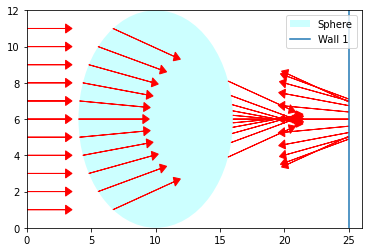

In [2]:
"""2D Ray Tracing Code - Follows a series of photons as they encounter a spherical lens, are focused to a point behind the lens, then hit the wall behind the lens and are reflected back.
This code traces rays by computing the distance to all the objects in a room (ie. walls, lenses) for a given photon and returning the closest object so the photon can interact with it. This is in lieu of stepping each photon in time."""


from dataclasses import dataclass
import numpy as np
from abc import ABC
import matplotlib.pyplot as plt
from typing import TypeVar,Generic
from functools import singledispatch


# walls are infinitely long, so the wall class has a position coordinate and a normal vector at its position    
@dataclass
class Wall(ABC):
    position: np.array([float(0),float(0)])
    normal: np.array([float(0),float(0)]) 
    def __init__(self,position=[0,0],normal=[1,0]):
        self.position=position
        self.normal=normal   

#spherical lens with a center, radius and the index of refraction of the lens material       
@dataclass
class Sphere(ABC):
    center: np.array([float(0),float(0)]) #"Current Center of Sphere"
    radius: float(0) #"Current Radius of Sphere"
    ior: float(0) #"Current Index of Refraction"
    def __init__(self,center=[0,0],radius=0.0,ior=0.0):
        self.center=center
        self.radius=radius
        self.ior=ior
        
# a photon is a single particle of light, represented by an arrow. It has a current position vector p and a travel direction #vector l, that represents the direction of travel. It also tracks the current index of refraction of the medium where the
#photon is located.
@dataclass
class Photon:
    p: np.array([float(0),float(0)]) #"Position vector"
    l: np.array([float(0),float(0)]) #"Direction vector"
    ior: float(0) #"Current Index of Refraction"
    def __init__(self,p=[0,0],l=[0,0],ior=1.0):
        self.p=p
        self.l=l
        self.ior=ior

#class Miss and Intersection are used to track which walls or spheres the photon hits versus which walls or spheres the photon #misses.
@dataclass
class Miss:
    path:str

#Intersection class that stores the intersection information between the wall or sphere and a photon
#Intersection is with a Wall or Sphere object, the distance to the object and the intersection coordinates
T=TypeVar("R")
@dataclass
class Intersection(Generic[T]):  #Generic[T] allows the intersection with a Wall or Sphere object
    object: T  #will be either the wall or the sphere
    distance: float(0)
    point: np.array([float(0),float(0)]) 
    def __init__(self,object=T,distance=0.0,point=[0,0]):
        self.object=object
        self.distance=distance
        self.point=point 

#normalizes a vector
def normalize(v): #v:: numpy array
    return v/np.linalg.norm(v) #returns the normalized vector



#plots one wall at a time, uses count of total number of walls and labels them
def plot_wall(n,wall): #n::Integer, wall::Wall
    #since walls are infinite, plots a portion of the infinite wall at the wall position
    adjacent = np.array([wall.normal[1], -wall.normal[0]])

    a = wall.position + adjacent * 20
    b = wall.position + adjacent * -20

    line = [a, b]

    x_vals = [a[0] for a in line] #creates a plottable x and y set of values
    y_vals = [a[1] for a in line]

    plt.plot(x_vals,y_vals, label="Wall {}".format(n))
    return

#plots a sphere
def plot_sphere(sphere): #sphere::Sphere
    circle1 = plt.Circle(sphere.center, sphere.radius, fc='cyan', alpha=0.2, label="Sphere")
    plt.gca().add_patch(circle1) #fills the circle to look like a sphere
    return

#plots all room walls and spheres
def plot_scene(objects): #objects::Wall or Spheres
    for count,o in enumerate(objects):
        if isinstance(o,Wall):
            plot_wall(count,o)
        else: plot_sphere(o)
    plt.xlim([0, 26]) #sets up the scene parameters for the photons and the room
    plt.ylim([0, 12])
    plt.legend()
    return

#plots a photon, with a specific defined length
def plot_photon(photon,length):  #photon::Photon, length:: integer
    plt.arrow(photon.p[0],photon.p[1],length*photon.l[0],length*photon.l[1], label="Photon",head_width=0.5, head_length=0.5, color='red')
    return 



#dispatches the photon to intersect with either a Wall or a Sphere
@singledispatch
def intersection(o,*kwargs): #o:Object, either a wall or sphere
    raise TypeError(f"Cannot convert {o}") #checks to make sure there is either a Wall or Sphere sent

#given a photon and a wall, what is the distance the photon will travel before intersecting the wall?
#Formula:
#final_distance = [-(position_photon - position_wall) \dot normal_wall] / [l_photon \dot normal_wall]
#Note that a negative distance means the photon and wall do not intersect
def intersection_distance_wall(wall, photon):  #wall::Wall, photon::Photon
    position_difference = -1*np.subtract(photon.p,wall.position)
    dot_with_wall_normal = np.dot(position_difference,wall.normal)
    photon_direction_dot_with_wall_normal = np.dot(photon.l,wall.normal)
    final_distance = dot_with_wall_normal/photon_direction_dot_with_wall_normal
    return final_distance    

#takes a photon and a wall, computes its intersection_distance and returns either a Miss or an Intersection object
#if there is an intersection, create new intersection instance, storing the wall, the distance to intersect and 
#the intersection point
#intersection point = position_photon + final_distance * l_photon
@intersection.register(Wall)
def intersection_wall(wall, photon, error=0.001): #wall::Wall, photon::Photon, error::float
    D = intersection_distance_wall(wall,photon)
    if D > error: #photon hits the wall
        point = np.add(photon.p,D*np.array(photon.l)) #the point where the photon and wall intersect
        return Intersection(wall,D,point)
    if (D <= error): #a negative distance means the photon and wall do not intersect
        return Miss

#Mathematics in photon/Sphere interaction: At any time does the photon interact with the sphere? If so, when?
#We can represent our photon travelling in time t
#photon_later position = photon.p + photon.l*time
#There are three possibilities: no intersection, exactly one point intersection: grazes the sphere,
#or two intersections: enters and exits the sphere.
#At what time does the photon interact with the sphere? Solve for time in the following equation.
#(photon.p + photon.l*time - sphere.center) \dot (photon.p + photon.l*time - sphere.center) = sphere.radius^2
#(photon.l \dot photon.l) *t^2 + 2*[(photon.p \dot photon.l - photon.l \dot sphere.center)] *t 
#+ (photon.p \dot photon.p -2*photon.p \dot sphere.center + sphere.center \dot sphere.center -sphere.radius^2) = 0
#This is a quadratic equation with at^2 + bt +c
# a= photon.l \dot photon.l
# b = 2*[(photon.p \dot photon.l - photon.l \dot sphere.center)]
# c = photon.p \dot photon.p -2*photon.p \dot sphere.center + sphere.center \dot sphere.center - sphere.radius^2
# If we find the roots of the discriminant of t, we can know how many intersections the photon has with the circle
# discriminant = b^2 - 4ac
# Zero soutions: photon does not interact with sphere
# One solution: photon intersects at only one point on sphere
# Two solutions: photon intersects sphere twice. Return closest point (smallest time)

def intersection_time_sphere(sphere,photon,error=0.001):  #sphere::Sphere, photon::Photon, error::float
    #finding the descriminant from the quadratic equation to see if the photon hits the sphere
    a = np.dot(photon.l,photon.l) # a in the discriminant
    
    p_dot_l = np.dot(photon.p,photon.l)
    l_dot_sphere_center = np.dot(photon.l,sphere.center)
    b = 2 * np.subtract(p_dot_l,l_dot_sphere_center)

    p_dot_p = np.dot(photon.p,photon.p)
    p_dot_sphere_center = np.dot(photon.p,sphere.center)
    sphere_center_dot_sphere_center = np.dot(sphere.center,sphere.center)
    
    c = p_dot_p - 2*p_dot_sphere_center + sphere_center_dot_sphere_center - sphere.radius**2
    descriminant = b**2 - 4*a*c
    #print("descriminant",descriminant)
    if descriminant > error: #find both time values and return the smallest/closest one greater than 0
        time1 = (-b + np.sqrt(descriminant))/(2*a)
        time2 = (-b - np.sqrt(descriminant))/(2*a)
        if (time1 > 0) and (time2 > 0):
            time = np.minimum(time1,time2)
        elif (time1 > 0) and (time2 <= 0):
            time = time1
        elif (time1 <= error) and (time2 > 0):
            time = time2
        elif (time1 <= error) and (time2 <= error):
            time = -1
    elif descriminant > 0 and descriminant <= error:
        time = (-b)/(2*a)
    else: time = -1
    return time
    
#a new method intersection that takes a Photon and a Sphere, and returns either a Miss or an Intersection, using the same #method as above for a wall   
@intersection.register(Sphere)
def intersection_sphere(sphere, photon, error=0.001): #sphere::Sphere, photon::Photon, error::float
    time = intersection_time_sphere(sphere,photon) #compute the intersection time to the Sphere
    if time > error: #photon hits the sphere
        point = np.add(photon.p,time*np.array(photon.l)) #photon_later position = photon.p + photon.l*time
        return Intersection(sphere,time,point)
    if (time <= error): #a negative time means the photon and sphere do not intersect
        return Miss

    

#reflect returns the new direction (ℓ2) of the photon after it hits a wall
#in cartesian coordinates, our reflected direction is
#ℓ2 = ℓ₁ - 2 * (ℓ₁ \dot n̂) * n̂
#the initial amount of light moving in the surface normal's direction is subtracted twice to find the new direction of the light
#ℓ₁ and ℓ2 are the photon directions before and after the reflection off a wall with normal n̂.

def reflect(l_1,n): #l_1::Photon.p, n::Wall.normal
    l_1_dot_n = np.dot(l_1,n) #gives a scalar of the amount of light reflected off the wall surface normal
    total_subtract = 2*np.array(n)*l_1_dot_n #gives a x and y value again
    l_2 = np.subtract(l_1,total_subtract)
    return l_2 #returns the reflected vector direction



#refracts light between two media and returns the refracted photon direction
#We can write a Cartesian form of Snell's law to determine the direction of Photon travel after refraction
#Formula: let r = index of refraction in first medium/index of refraction in second medium
#Let c = -n̂ \dot ℓ₁ where n̂ is the sphere surface normal and ℓ₁ is the direction of the photon before refraction
#ℓ2 = normalize(r * ℓ₁ + (r*c - sqrt(1 - r^2 * (1 - c^2))) * n̂)
def refract(l_1, n , old_ior, new_ior): #l_1::Photon.l, n::Vector; normal to sphere, old_ior::float, new_ior::float
    r = old_ior / new_ior #scalar
    if -1*np.dot(l_1,n) < 0:
        normal_to_sphere = -n
    else: normal_to_sphere = n
    c = -1 * np.dot(normal_to_sphere,l_1) #scalar value 
    vector1 = r * np.array(l_1)
    sqrt_const = np.float64(r*c - np.sqrt(1 - r**2 * (1 - c**2)))
    vector2 = np.multiply(sqrt_const,normal_to_sphere)
    l_2 = normalize(np.add(vector1,vector2))
    return l_2    

#find the normal to the sphere's surface that was hit. Needs a normalized vector returned.
#The normal points perpendicular to the surface of the sphere. 
#n = normalized vector of (photon.p - sphere.center)
def sphere_normal_location(photon,object):  #photon::Photon, object::Sphere
    return normalize(np.subtract(photon.p,object.center)) #returns normal to the surface of the sphere
    
    

#interact returns a new Photon after hitting its closest hit (either a wall or a sphere)
#the new Photon is located at the hit point, its direction, l, is reflected or refracted depending on whether it hits a wall or sphere, and its index of refraction in its new medium is updated, if applicable.
def interact(hit,photon):  #hit:: type Intersection(Wall,D, point) or Intersection(Sphere,D,point),photon::Photon
    if isinstance(hit.object,Wall):
        new_l = reflect(photon.l,hit.object.normal) #finds new l of photon after reflection
        hit_info = intersection(hit.object,photon,error=0.001) #retrieves hit point location coordinates
        return Photon(hit_info.point,new_l,photon.ior) #returns new Photon; ior does not change for wall hit
    elif isinstance(hit.object,Sphere):
        normal_sphere = sphere_normal_location(photon,hit.object) # find the normal to the surface of the sphere
        new_l = refract(photon.l,normal_sphere,photon.ior,hit.object.ior) #find the new direction of the photon
        hit_info = intersection(hit.object, photon, error=0.001)
        return Photon(hit_info.point,new_l,hit.object.ior) #returns a new photon in the with new IOR

#takes a photon and a vector of all possible intersection objects. Looks at only the Intersection objects and 
#returns the closest hit.
def closest_hit(photon, objects): #photon::Photon, objects::vector of Intersection and Miss objects
    intersection_list = []
    for o in objects: #go through each object and make a list of only those that have intersected
        if isinstance(o,Intersection):
            intersection_list.append(o)
    min_D_value = intersection_list[0].distance #first set the minimum distance to the first intersection then compare to rest
    hit = intersection_list[0]
    for i in intersection_list:
        if i.distance < min_D_value:
            hit = i
            min_D_value = i.distance
    return hit  #returns closest hit: Intersection object with stored intersection details

#step_ray takes in a photon and a vector of all possible intersection objects
#it finds the closest hit and computes the interaction.
def step_ray(photon,objects):  #photon::Photon, objects::vector of Intersection or Miss Objects
    hit = closest_hit(photon, objects) #returns the object the photon actually hit - closest wall or sphere
    return interact(hit,photon) #returns the new Photon object that has hit the closest wall or sphere



#Sends a photon into the room and returns a series of new photon properties that represent the encounters with each room object
def trace(photon,scene,N):  #photon::Photon, scene::vector of room objects, n::Integer number of steps
    all_intersections = [intersection(item,photon,error=0.001) for item in scene] #finds all intersection of the photon with the 
                                                                                  #room one at a time
    new_photon = [step_ray(photon,all_intersections)] #finds first encounter with the first object in the room and returns new 
                                                      #photon object with new photon properties
    for i in range(N):
        all_intersections = [intersection(item,new_photon[i],error=0.001) for item in scene] #finds intersections of new photon
                                                                                             # with the room
        next_hit_photon = step_ray(new_photon[i],all_intersections) #next hit photon object with new properties
        new_photon.append(next_hit_photon) #append to list of photon encounters
        plot_photon(new_photon[i], 5) # plots photon
    return new_photon #returns vector of all photon encounters for a given photon

#Traces each photon through a series of encounters in the room and plots them
def send_many_photons(photons,scene): #photons:: array of objects of class Photon, scene:: objects in room like Wall or  
                                        #Sphere
    number_steps = 3 #number of times a photon reflects or refracts in the room
    for i in photons:
        plot_photon(i, 3) #plots the initial photon in the room with length 3
        new_photons = trace(i,scene,number_steps) #traces each photon into the room and sets number of steps to take
    return



#initialize 12 photons in the room; room is made of air so index of refraction = 1.0
room_photons=[]
for x in range(1,12):
    room_photons.append(Photon([0, x], [1,0], 1.0))

#create a room with a sphere and a wall
room = [Sphere([10, 6],6,3.0),Wall([25,6],[1,0])]
plot_scene(room)

send_many_photons(room_photons,room)
plt.show()